In [17]:
!pip install opencv-python

In [18]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from shutil import rmtree

In [19]:
OTHER = os.path.join(os.path.abspath("."), "frames")
PATH = os.path.join(os.path.abspath("."), "frames", "object_detection")
MODEL = os.path.join(os.path.abspath("."), "malfunction_detection_model")
OBJECTS = os.path.join(MODEL, "images")
DATA = os.path.join(MODEL, "data")
CSV_PATH = os.path.join(DATA, "malfunction_labels.csv")
TRAIN_CSV_PATH = os.path.join(DATA, "train_labels.csv")
TEST_CSV_PATH = os.path.join(DATA, "test_labels.csv")

In [20]:
if os.path.exists(OBJECTS):
    rmtree(OBJECTS)
os.makedirs(OBJECTS)

In [21]:
if os.path.exists(DATA):
    rmtree(DATA)
os.makedirs(DATA)

In [22]:
def isolate_malfunctions(stable_image_path, malfunction_image_path, csv_file):
    global COUNTER, OBJECTS
    stable = cv2.imread(stable_image_path)
    malfunction = cv2.imread(malfunction_image_path)
    original = malfunction.copy()
    filename = os.path.split(malfunction_image_path)[-1]
    # we subtract the malfunction image from the stable one.
    image = cv2.absdiff(malfunction, stable)
    # we produce a kernel (a 5x5 matrix filled with value 1)
    kernel = np.ones((5,5), np.uint8)
    # we erode the image to get rid of the contours left behind from the global noise.
    image = cv2.erode(image, kernel, iterations=2)
    # map the image's colormap to hsv.
    image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    # we produce a mask by selecting non-black regions of the eroded image.
    lower_white = np.array([10,10,10])
    upper_white = np.array([255,255,255])
    mask = cv2.inRange(image, lower_white, upper_white)
    # find the contours of the mask
    cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    

    def bbArea(c):
        _,_,w,h = cv2.boundingRect(c)
        return w*h

    # Since we have general noise it's best to skip over small captured
    # malfunction regions. This is a more suitable solution than trying
    # to erode the image for 2 iterations since it makes us lose parts of
    # the targeted region. An idea is to use percentiles.
    mean = np.array([bbArea(c) for c in cnts]).mean()
    offset = 20
    wrote_once = False
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        if w * h > mean:
            if not wrote_once:
                cv2.imwrite(os.path.join(OBJECTS, filename), original)
                wrote_once = True
            cv2.rectangle(malfunction, (x - offset, y - offset), (x + w + offset, y + h + offset), (255,0,0), 2)
            print(",".join(map(str, [filename, original.shape[0], original.shape[1], "malfunction", x - offset, y - offset, x + w + offset, y + h + offset])), file=csv_file)
            plt.imshow(malfunction)

In [23]:
import glob
import io

from PIL import Image
from object_detection.utils import dataset_util
from collections import namedtuple, OrderedDict

In [24]:
stable_dir = glob.glob(os.path.join(PATH, "stable", "*.png"))
malfunction_dir = glob.glob(os.path.join(PATH, "malfunction","*.png"))

stable_prefix = "stable_" 
stable_dir.sort(key=lambda x: int(x[x.index(stable_prefix) + len(stable_prefix): -4]))

malfunction_prefix = "malfunction_" 
malfunction_dir.sort(key=lambda x: int(x[x.index(malfunction_prefix) + len(malfunction_prefix): -4]))

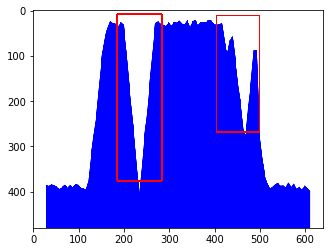

In [25]:
with open(CSV_PATH, "w", encoding="utf-8") as csv_file:
    print(",".join(["filename", "width", "height", "class", "xmin", "ymin", "xmax", "ymax"]), file=csv_file)
    for (stable_path, malfunction_path) in zip(stable_dir, malfunction_dir):
        isolate_malfunctions(stable_path, malfunction_path, csv_file)

In [26]:
data = pd.read_csv(CSV_PATH)
train = data.sample(frac=0.80, random_state=42)
train.to_csv(TRAIN_CSV_PATH, sep=',', index=False)
test = data.drop(train.index)
test.to_csv(TEST_CSV_PATH, sep=',', index=False)

In [27]:
def class_text_to_int(row_label):
    if row_label == 'malfunction':
        return 1
    else:
        None

def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]

def create_tf_example(group, path):
    with tf.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size
    filename = group.filename.encode('utf8')
    image_format = b'png'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example

In [28]:
def generate_tfrecords(files):
    for file in files:
        name = os.path.basename(file).split(".")[0]
        writer = tf.python_io.TFRecordWriter(os.path.join(DATA, "{}.record".format(name)))
        path = os.path.join(OBJECTS)
        examples = pd.read_csv(file)
        grouped = split(examples, 'filename')
        for group in grouped:
            tf_example = create_tf_example(group, path)
            writer.write(tf_example.SerializeToString())
        writer.close()

In [29]:
generate_tfrecords([TRAIN_CSV_PATH, TEST_CSV_PATH])

In [30]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15193567570647793818
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1360193126
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15813837230925693479
physical_device_desc: "device: 0, name: GeForce GTX 960M, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [34]:
def convert_frames_to_video(fileout, path):
    frame_array = []
    files = glob.glob(os.path.join(*path, "*.png"))
    prefix = "malfunction_"

    #for sorting the file names properly
    files.sort(key = lambda x: int(x[x.index(prefix)+len(prefix):-4]))

    for i in range(len(files)):
        filename= files[i]
        #reading each files
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        #inserting the frames into an image array
        frame_array.append(img)

    out = cv2.VideoWriter(os.path.join(DATA, "{}.avi".format(fileout)), cv2.VideoWriter_fourcc(*'DIVX'), 15, size)

    for i in range(len(frame_array)):
        # writing to a image array
        out.write(frame_array[i])
    cv2.destroyAllWindows()
    out.release()

In [35]:
convert_frames_to_video("malfunction_frames_train", [OTHER, "train", "malfunction"])
convert_frames_to_video("malfunction_frames_valid", [OTHER, "valid", "malfunction"])

on_146.png', 'c:\\Users\\HeiligesLicht\\Desktop\\DLRS\\src\\frames\\object_detection\\malfunction\\malfunction_147.png', 'c:\\Users\\HeiligesLicht\\Desktop\\DLRS\\src\\frames\\object_detection\\malfunction\\malfunction_148.png', 'c:\\Users\\HeiligesLicht\\Desktop\\DLRS\\src\\frames\\object_detection\\malfunction\\malfunction_149.png', 'c:\\Users\\HeiligesLicht\\Desktop\\DLRS\\src\\frames\\object_detection\\malfunction\\malfunction_15.png', 'c:\\Users\\HeiligesLicht\\Desktop\\DLRS\\src\\frames\\object_detection\\malfunction\\malfunction_150.png', 'c:\\Users\\HeiligesLicht\\Desktop\\DLRS\\src\\frames\\object_detection\\malfunction\\malfunction_151.png', 'c:\\Users\\HeiligesLicht\\Desktop\\DLRS\\src\\frames\\object_detection\\malfunction\\malfunction_152.png', 'c:\\Users\\HeiligesLicht\\Desktop\\DLRS\\src\\frames\\object_detection\\malfunction\\malfunction_153.png', 'c:\\Users\\HeiligesLicht\\Desktop\\DLRS\\src\\frames\\object_detection\\malfunction\\malfunction_154.png', 'c:\\Users\\Heil